Importing Required Libraries

In [16]:
import math
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
import csv
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from astroquery.jplhorizons import Horizons
from astropy.time import Time
import astropy.units as u
from scipy import stats
from datetime import datetime

Transform the coordinate system to the refence one

In [24]:
# Configuration: targets and date
targets = {
    "Earth": "399",
    "Jupiter": "599",
    "2025 PM": "2025 PM",  # Add other asteroids if desired
}

query_date = "2025-08-12"

# Utility: normalize a vector
def normalize(v):
    return v / np.linalg.norm(v)

# Transform function: rotate heliocentric frame and translate Earth to (1 AU, 0, 0)
def transform_to_rotated_heliocentric_frame(pos_obj, vel_obj, pos_earth, vel_earth):
    # Build rotation axes using Earth’s state
    x_axis = normalize(pos_earth)
    z_axis = normalize(np.cross(pos_earth, vel_earth))
    y_axis = np.cross(z_axis, x_axis)

    R = np.vstack([x_axis, y_axis, z_axis]).T  # Rotation matrix

    # Rotate Earth and object vectors
    pos_earth_rot = R.T @ pos_earth.to(u.AU).value
    vel_earth_rot = R.T @ vel_earth.to(u.AU / u.day).value

    pos_obj_rot = R.T @ pos_obj.to(u.AU).value
    vel_obj_rot = R.T @ vel_obj.to(u.AU / u.day).value

    # Translate so Earth is at [1 AU, 0, 0]
    translation = np.array([1.0, 0.0, 0.0]) - pos_earth_rot
    pos_obj_rot_translated = pos_obj_rot + translation
    vel_obj_rot_translated = vel_obj_rot  # velocity not translated

    # Convert units
    pos_m = (pos_obj_rot_translated * u.AU).to(u.m)
    vel_ms = (vel_obj_rot_translated * u.AU / u.day).to(u.m / u.s)

    return pos_m, vel_ms

# Main processing function
def process_targets(targets, date_str):
    jd = Time(date_str).jd

    results = {}

    # Fetch Earth’s heliocentric state
    earth = Horizons(id='399', location='500@10', epochs=[jd])
    ev = earth.vectors()
    pos_earth = np.array([ev['x'][0], ev['y'][0], ev['z'][0]]) * u.AU
    vel_earth = np.array([ev['vx'][0], ev['vy'][0], ev['vz'][0]]) * u.AU / u.day

    for name, tid in targets.items():
        obj = Horizons(id=tid, location='500@10', epochs=[jd])
        ov = obj.vectors()
        pos_obj = np.array([ov['x'][0], ov['y'][0], ov['z'][0]]) * u.AU
        vel_obj = np.array([ov['vx'][0], ov['vy'][0], ov['vz'][0]]) * u.AU / u.day

        pos_m, vel_ms = transform_to_rotated_heliocentric_frame(pos_obj, vel_obj, pos_earth, vel_earth)

        results[name] = {
            'pos_m': pos_m.value,
            'vel_ms': vel_ms.value
        }

    return results

# Run the process and display output
if __name__ == "__main__":
    data = process_targets(targets, query_date)
    for name, result in data.items():
        print(f"\n🔸 {name}")
        print(f"   Position (rotated, m): {result['pos_m']}")
        print(f"   Velocity (rotated, m/s): {result['vel_ms']}")

        
def signed_angle(a, b, axis):
    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    dot = np.clip(np.dot(a, b), -1.0, 1.0)
    angle = np.arccos(dot)
    cross = np.cross(a, b)
    if np.dot(axis, cross) < 0:
        angle = -angle
    return np.degrees(angle)



🔸 Earth
   Position (rotated, m): [1.49597871e+11 0.00000000e+00 0.00000000e+00]
   Velocity (rotated, m/s): [-2.85754356e+02  2.93780639e+04  3.66650247e-16]

🔸 Jupiter
   Position (rotated, m): [-5.74800922e+11  5.17500585e+11 -9.79251247e+08]
   Velocity (rotated, m/s): [-9283.27095722 -9339.89824668   297.39693969]

🔸 2025 PM
   Position (rotated, m): [ 1.55893506e+11  2.41297820e+08 -9.21946436e+08]
   Velocity (rotated, m/s): [-13719.68501303  30989.52412866   1199.28728342]


get phase difference of jupiter an earth at t= 0

In [25]:
# Extract rotated positions of Earth and Jupiter
earth_pos = data["Earth"]["pos_m"]
jupiter_pos = data["Jupiter"]["pos_m"]

# Convert to numpy arrays
earth_vec = np.array(earth_pos)
jupiter_vec = np.array(jupiter_pos)

# Project both onto the XY-plane
earth_proj = earth_vec[:2]  # [x, y]
jupiter_proj = jupiter_vec[:2]

# Compute signed angle between Earth and Jupiter in the XY-plane
def signed_angle_2d(a, b):
    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    angle = np.arctan2(b[1], b[0]) - np.arctan2(a[1], a[0])
    return np.degrees((angle + 360) % 360)  # Normalize to [0, 360)

phi = signed_angle_2d(earth_proj, jupiter_proj)       # phase for jupiter
print(f"\n🌀 Phase difference (Earth → Jupiter): {phi:.2f} degrees")


🌀 Phase difference (Earth → Jupiter): 138.00 degrees


Global constants

In [26]:
# --- Constants ---
# --- Universal and time ---
AU = 1.496e11                    # m
c = 3e8                          # m/s
G = 6.67430e-11                  # N·m²/kg²

# --- Earth ---
M_E = 5.972e24                   # kg
earth_radius = 6370e3            # m
T = 60 * 60 * 24 * 365.25        # s (1 year)
omega = 2 * np.pi / T            # rad/s

#test
#omega = 1.963867219512878e-07



# --- Jupiter ---
M_J = 1.8986e27
jupiter_radius = 7.1492e7        # m
distance_sun_jupiter=  778547200000  # m
T_j = 4333*24*60*60              # s (11.86 earth year = 1 jupiter year)
omega_J = 2 * np.pi / T_j        # rad/s                     
i_deg = 1.304                    # inclination angle
Omega_deg = 100.464              # Longitude of ascending node


# --- Sun ---
M_S = 1.989e30                   # kg
sun_radius = 695700e3            # m


r_earth_moon = 3.844e8           # m

Initial Conditions and functions

In [27]:
observer_pos_init = np.array(data["2025 PM"]["pos_m"])
observer_vel_init = np.array(data["2025 PM"]["vel_ms"])


# --- Jupiter orbit ---
@njit 
def j_p(t):
    theta = omega_J * t + math.radians(phi)
    r_orb = np.array([distance_sun_jupiter*np.cos(theta), distance_sun_jupiter * np.sin(theta), 0.0])
    Rz = np.array([[np.cos(np.deg2rad(Omega_deg)), -np.sin(np.deg2rad(Omega_deg)), 0.0],
                   [np.sin(np.deg2rad(Omega_deg)),  np.cos(np.deg2rad(Omega_deg)), 0.0],
                   [0.0,                            0.0 ,                          1.0]])
    Rx = np.array([[1.0, 0,                          0],
                   [0.0, np.cos(np.deg2rad(i_deg)), -np.sin(np.deg2rad(i_deg))],
                   [0.0, np.sin(np.deg2rad(i_deg)),  np.cos(np.deg2rad(i_deg))]])
    return Rz @ (Rx @ r_orb)

# --- Earth orbit ---
@njit
def r_p(t):
    return np.array([
        AU * math.cos(omega * t),
        AU * math.sin(omega * t),
        0.0
    ])


# --- Retarded time using fixed point method ---
@njit
def retarded_time(t, observer_pos, tol=1e-6, max_iter=100, jupiter = 0):
    t_prime = t - np.linalg.norm(observer_pos) / c
    if jupiter == 1:
        for _ in range(max_iter):
            jupiter_pos = j_p(t_prime)
            d = np.linalg.norm(observer_pos - jupiter_pos)
            t_next = t - d / c
            if abs(t_next - t_prime) < tol:
                return t_next
            t_prime = t_next
        return t_prime
    else:
        for _ in range(max_iter):
            earth_pos = r_p(t_prime)
            d = np.linalg.norm(observer_pos - earth_pos)
            t_next = t - d / c
            if abs(t_next - t_prime) < tol:
                return t_next
            t_prime = t_next
        return t_prime

# --- Gravitational field from Sun and Earth ---
@njit
def grav_field(t, x1, jupiter = 0):
    
    g_jupiter=np.zeros(3)
    if jupiter != 0:
        t_ret = retarded_time(t,x1, jupiter=1)
        jupiter_pos = j_p(t_ret)
        r_j = np.linalg.norm(x1 - jupiter_pos)
        g_jupiter = -G * M_J / (r_j ** 2) * (x1 - jupiter_pos)/r_j
    
    t_ret = retarded_time(t, x1)
    earth_pos = r_p(t_ret)
    r_e = np.linalg.norm(x1 - earth_pos)
    g_earth = -G * M_E / (r_e**2) * (x1 - earth_pos) / r_e

    r_s = np.linalg.norm(x1)
    g_sun = -G * M_S / (r_s**2) * x1 / r_s

    return g_earth + g_sun + g_jupiter

# --- Adaptive time step ---
@njit
def find_dt(v, s, velocity_threshold=30000.0, small_dt=100.0, large_dt=1000.0, t=0.0):
    speed = np.linalg.norm(v)
    dist = np.linalg.norm(s - r_p(t))
    if speed > velocity_threshold or dist < 2.5 * AU:
        return small_dt
    else:
        return large_dt

# --- Simulate one particle ---
@njit
def simulate_one(s0, v0, t_max=T*2, jupiter_flag=0):
    max_steps = int(t_max / 50) + 1000
    s = s0.copy()
    v = v0.copy()
    t = 0.0
    traj = np.zeros((max_steps, 3))
    i = 0
    min_dist = np.inf
    jupiter_min_dist = np.inf
    while t < t_max and i < max_steps:
        traj[i] = s
        dt = find_dt(v, s, t=t)
        a = grav_field(t, s, jupiter_flag )
        s_new = s + v * dt + 0.5 * a * dt * dt
        v_new = v + a * dt
        t += dt

        r_sun = np.linalg.norm(s_new)
        r_earth = np.linalg.norm(s_new - r_p(t))
        r_jupiter = np.linalg.norm(s_new-j_p(t))
        min_dist = min(min_dist, r_earth)
        jupiter_min_dist = min(jupiter_min_dist, r_jupiter)

        if r_sun <= sun_radius:
            return traj[:i+1], 2, min_dist, jupiter_min_dist  # sun collision, min_dist = sun_radius
        elif r_earth <= earth_radius:
            return traj[:i+1], 1,min_dist, jupiter_min_dist  # earth collision, min_dist = earth_radius
        elif jupiter_flag != 0 and r_jupiter <= jupiter_radius:
            return traj[:i+1], 3, min_dist, jupiter_min_dist  # jupiter collision, mid_dist = jupiter_radius
        s = s_new
        v = v_new
        i += 1

    return traj[:i], 0, min_dist, jupiter_min_dist  # no collision, return actual min_dist

def generate_initial_conditions(n_particles, sigma_pos, sigma_vel):
    s0_list = np.random.normal(loc=observer_pos_init, scale=sigma_pos, size=(n_particles, 3))
    v0_list = np.random.normal(loc=observer_vel_init, scale=sigma_vel, size=(n_particles, 3))
    return s0_list, v0_list


def monte_carlo_sim_from_initials(s0_list, v0_list, t_max_years, output_file, jupiter_flag=0):
    with open(output_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            "ParticleID",
            "InitialSpeed(m/s)",
            "InitialPosX(m)",
            "InitialPosY(m)",
            "InitialPosZ(m)",
            "CollisionType",
            "MinEarthDistance(m)",
            "MinJupiterDistance(m)"
        ])

        for i, (s0, v0) in enumerate(zip(s0_list, v0_list)):
            print(i)
            initial_speed = np.linalg.norm(v0)
            _, collision, min_dist, jupiter_min_dist = simulate_one(s0, v0, t_max=T * t_max_years, jupiter_flag=jupiter_flag)
            writer.writerow([i, initial_speed, s0[0], s0[1], s0[2], collision, min_dist, jupiter_min_dist])
    

Execution

In [28]:
# --- Read and summarize results ---
def summarize_results(output_file="collision_data.csv"):
    df = pd.read_csv(output_file)
    total = len(df)
    earth_hits = (df["CollisionType"] == 1).sum()
    sun_hits = (df["CollisionType"] == 2).sum()
    jupiter_hits = (df["CollisionType"]==3).sum()
    print("\n--- Collision Summary from CSV ---")
    print(f"Total Simulation : {total}")
    print(f"Earth Collisions        : {earth_hits} ({earth_hits/total:.2%})")
    print(f"Jupiter Collisions        : {jupiter_hits} ({jupiter_hits/total:.2%})")
    print(f"Sun Collisions          : {sun_hits} ({sun_hits/total:.2%})")

if __name__ == "__main__":
    N = 1000
    print("Generating initial conditions...")
    s0_list, v0_list = generate_initial_conditions(N, sigma_pos=1e6, sigma_vel=10.0)

    print(f"Running {N} Monte Carlo simulations WITHOUT Jupiter...")
    monte_carlo_sim_from_initials(s0_list, v0_list, t_max_years=1/12, output_file="collision_no_jupiter.csv", jupiter_flag=0)

    print(f"Running {N} Monte Carlo simulations WITH Jupiter...")
    monte_carlo_sim_from_initials(s0_list, v0_list, t_max_years=1/12, output_file="collision_with_jupiter.csv", jupiter_flag=1)

    summarize_results("collision_no_jupiter.csv")
    summarize_results("collision_with_jupiter.csv")

Generating initial conditions...
Running 1000 Monte Carlo simulations WITHOUT Jupiter...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
2

Plots


File: collision_with_jupiter.csv
Earth Mean = 8.7355e+08, 95% CI = [8.7326e+08, 8.7384e+08]
Jupiter Mean = 8.7046e+11, 95% CI = [8.7046e+11, 8.7046e+11]


<IPython.core.display.Javascript object>


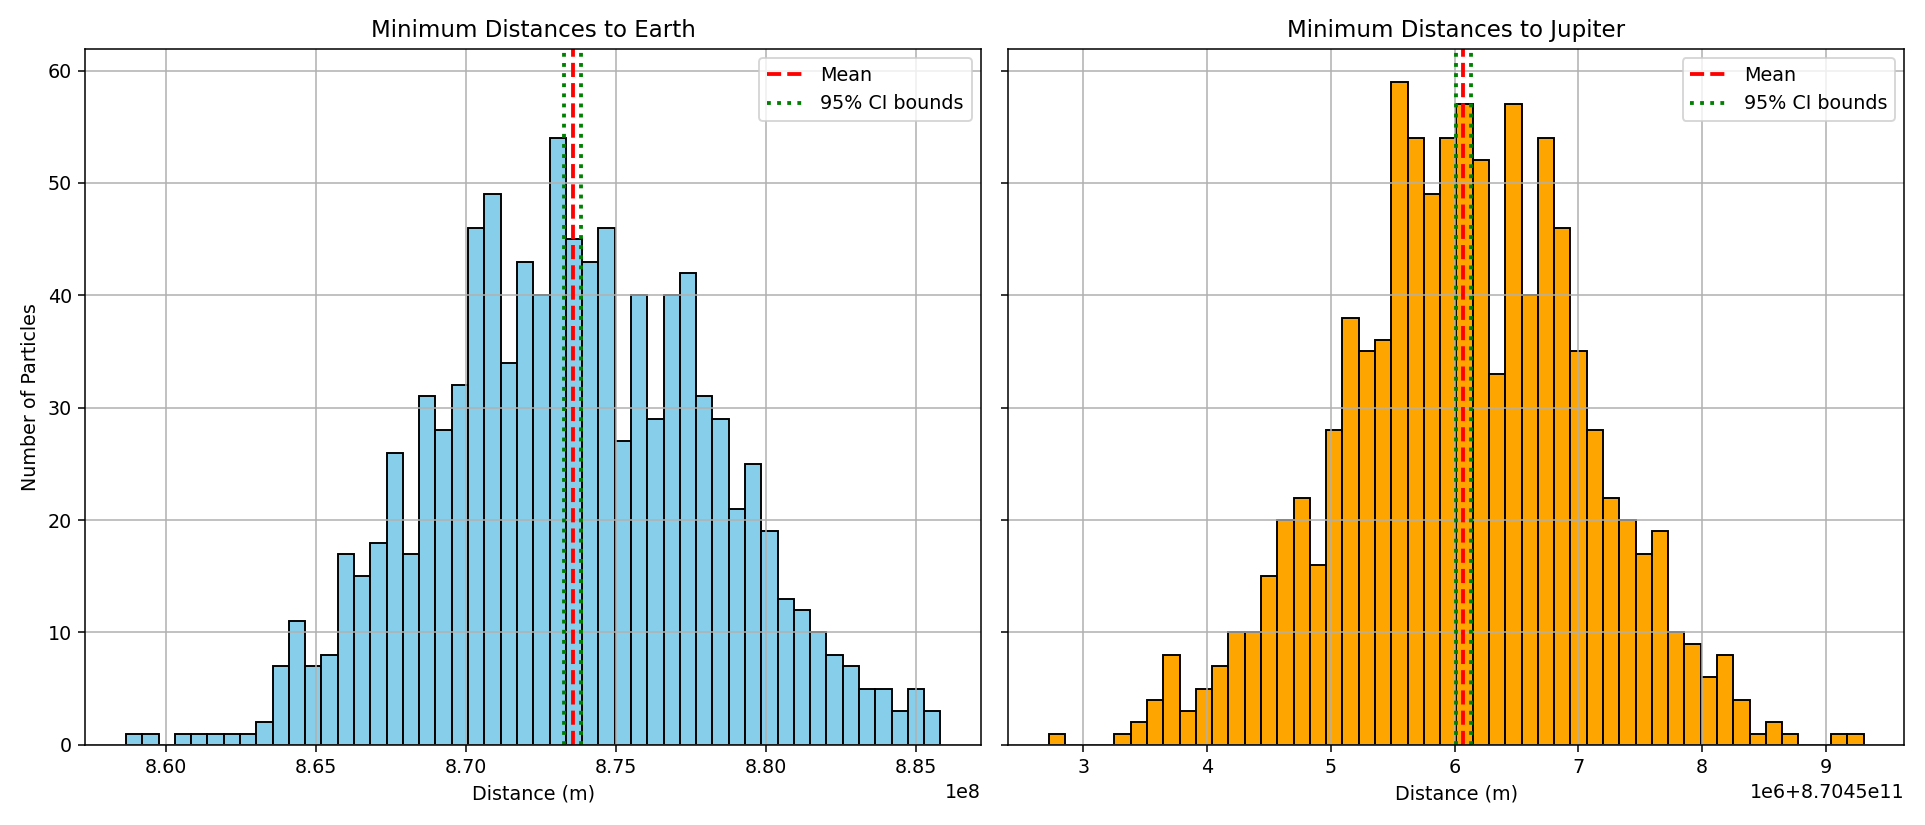


File: collision_no_jupiter.csv
Earth Mean = 8.7356e+08, 95% CI = [8.7327e+08, 8.7385e+08]
Jupiter Mean = 8.7046e+11, 95% CI = [8.7046e+11, 8.7046e+11]


<IPython.core.display.Javascript object>


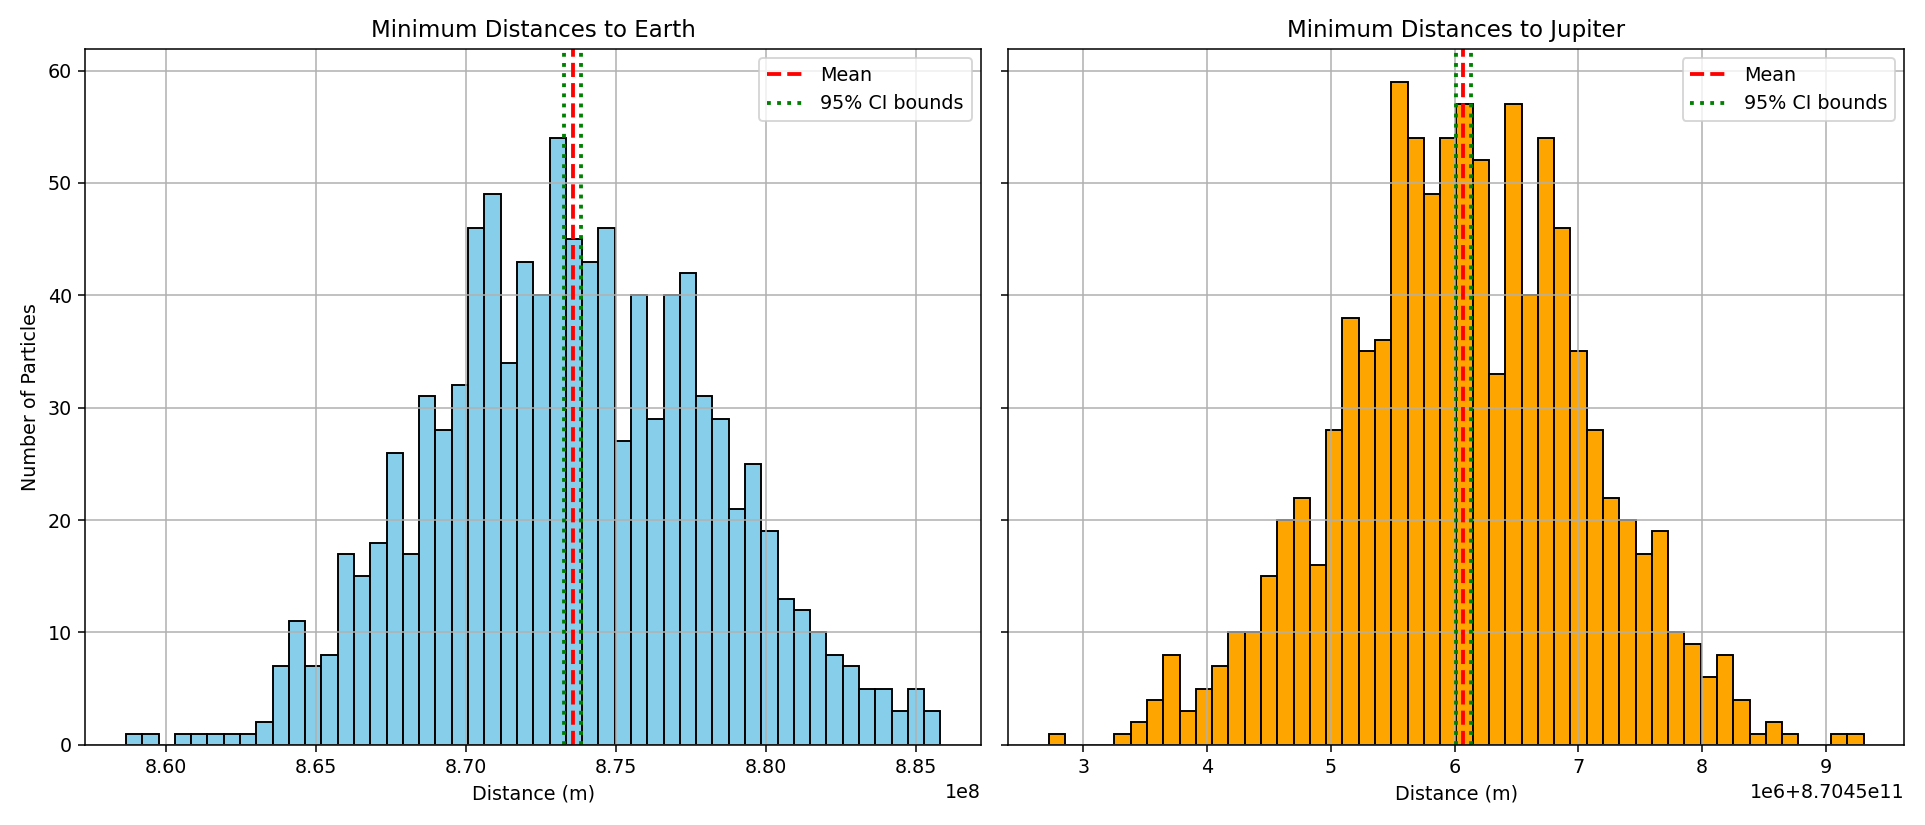

In [29]:
def plot_min_distance_histograms(csv_file="collision_data.csv", bins=50, confidence=0.95):
    min_earth_distances = []
    min_jupiter_distances = []

    # Read the CSV and extract distances
    with open(csv_file, mode='r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            try:
                earth_dist = float(row["MinEarthDistance(m)"])
                jupiter_dist = float(row.get("MinJupiterDistance(m)", "nan"))
                min_earth_distances.append(earth_dist)
                if not np.isnan(jupiter_dist):
                    min_jupiter_distances.append(jupiter_dist)
            except ValueError:
                continue

    # Function to calculate mean and CI from data
    def mean_ci(data, conf=confidence):
        arr = np.array(data)
        n = len(arr)
        mean = np.mean(arr)
        sem = stats.sem(arr)  # Standard Error of the Mean
        h = sem * stats.t.ppf((1 + conf) / 2., n - 1)  # CI half-width
        return mean, mean - h, mean + h

    # Calculate CIs
    earth_mean, earth_ci_low, earth_ci_high = mean_ci(min_earth_distances)
    jup_mean, jup_ci_low, jup_ci_high = mean_ci(min_jupiter_distances)

    # Print results
    print(f"\nFile: {csv_file}")
    print(f"Earth Mean = {earth_mean:.4e}, {confidence*100:.0f}% CI = [{earth_ci_low:.4e}, {earth_ci_high:.4e}]")
    print(f"Jupiter Mean = {jup_mean:.4e}, {confidence*100:.0f}% CI = [{jup_ci_low:.4e}, {jup_ci_high:.4e}]")

    # Create two subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # Earth histogram
    axes[0].hist(min_earth_distances, bins=bins, color='skyblue', edgecolor='black')
    axes[0].axvline(earth_mean, color='red', linestyle='dashed', linewidth=2, label="Mean")
    axes[0].axvline(earth_ci_low, color='green', linestyle='dotted', linewidth=2, label="95% CI bounds")
    axes[0].axvline(earth_ci_high, color='green', linestyle='dotted', linewidth=2)
    axes[0].set_title("Minimum Distances to Earth")
    axes[0].set_xlabel("Distance (m)")
    axes[0].set_ylabel("Number of Particles")
    axes[0].legend()
    axes[0].grid(True)

    # Jupiter histogram
    axes[1].hist(min_jupiter_distances, bins=bins, color='orange', edgecolor='black')
    axes[1].axvline(jup_mean, color='red', linestyle='dashed', linewidth=2, label="Mean")
    axes[1].axvline(jup_ci_low, color='green', linestyle='dotted', linewidth=2, label="95% CI bounds")
    axes[1].axvline(jup_ci_high, color='green', linestyle='dotted', linewidth=2)
    axes[1].set_title("Minimum Distances to Jupiter")
    axes[1].set_xlabel("Distance (m)")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Example run
plot_min_distance_histograms("collision_with_jupiter.csv")
plot_min_distance_histograms("collision_no_jupiter.csv")


Plot the path for selcted values

<IPython.core.display.Javascript object>


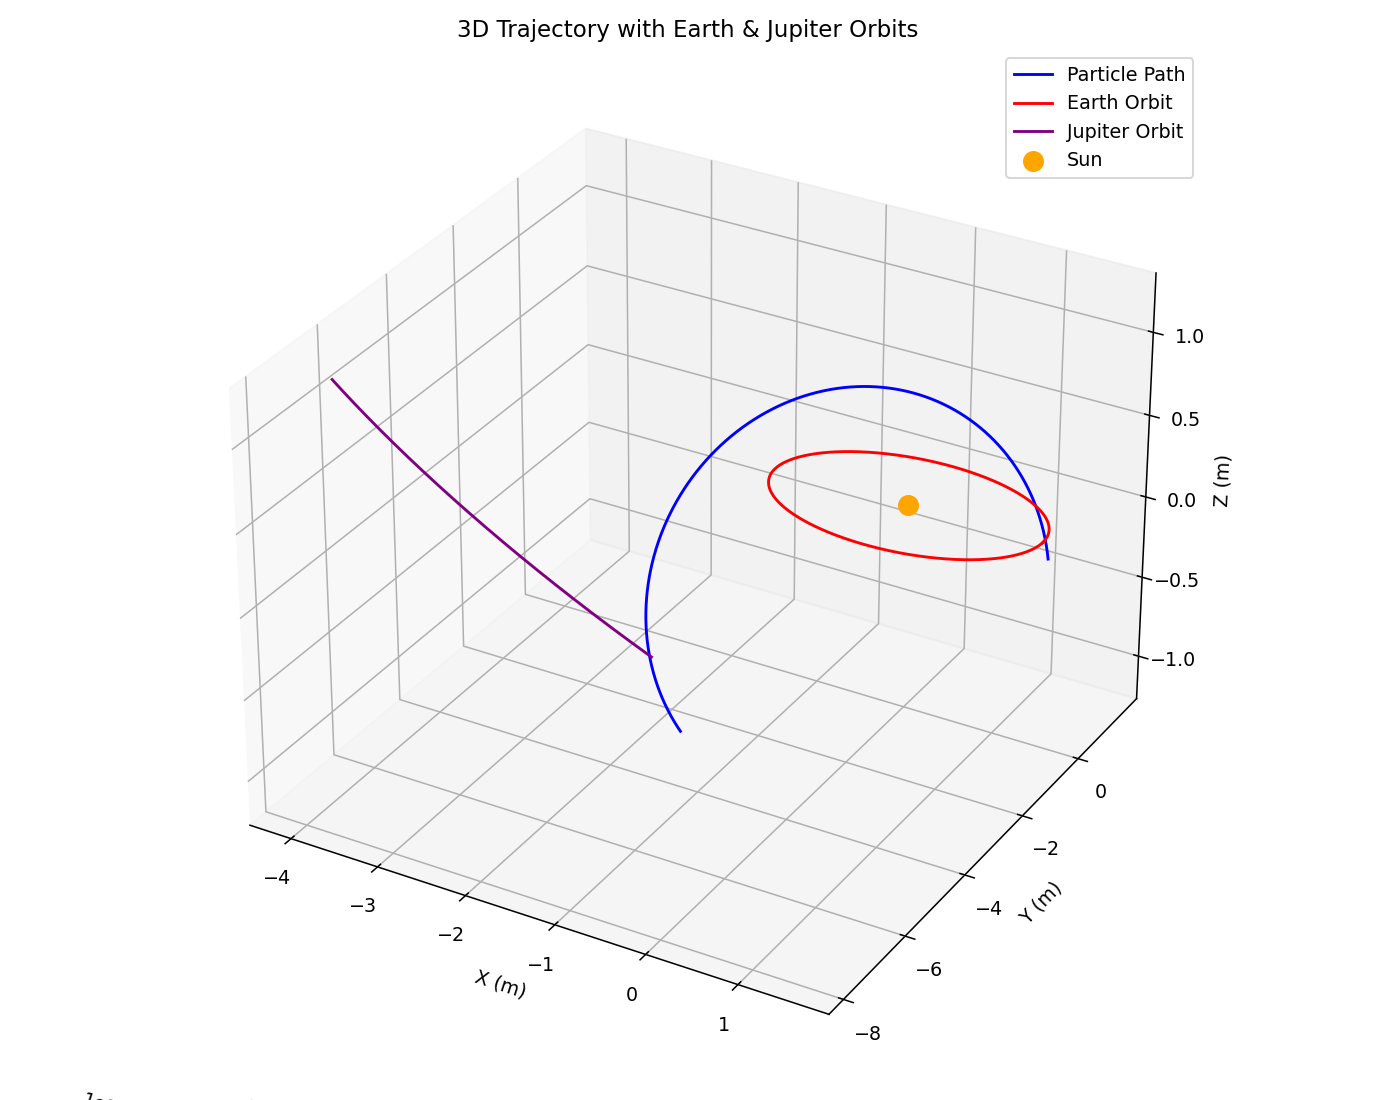

<IPython.core.display.Javascript object>


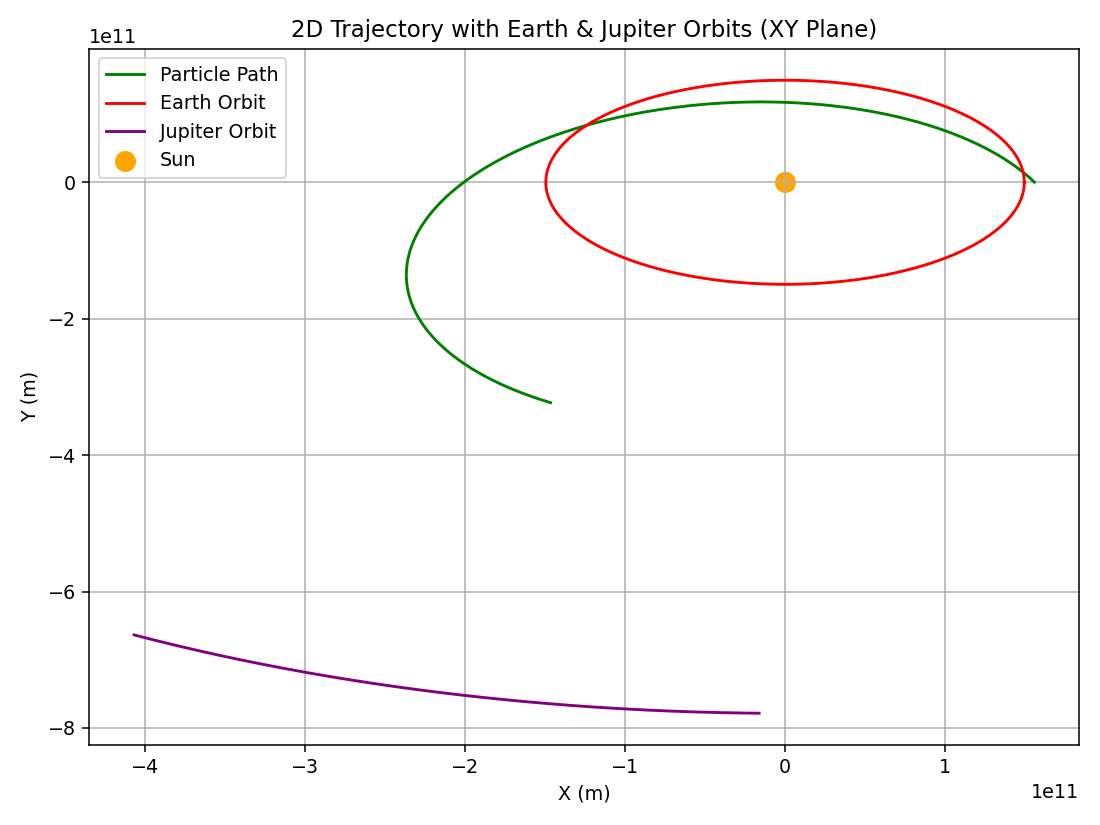

In [30]:
%matplotlib notebook
# --- Sample Earth's path over time --- 
def get_earth_path(t_max, dt=10000.0): 
    times = np.arange(0, t_max, dt) 
    earth_path = np.array([r_p(t) for t in times]) 
    return earth_path
def get_jupiter_path(t_max, dt=10000.0): 
    times = np.arange(0, t_max, dt) 
    jupiter_path = np.array([j_p(t) for t in times]) 
    return jupiter_path

# --- 3D Plot with Earth & Jupiter ---
def plot_trajectory_3d(traj, earth_path, jupiter_path):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], color='blue', label='Particle Path')
    ax.plot(earth_path[:, 0], earth_path[:, 1], earth_path[:, 2], color='red', label='Earth Orbit')
    ax.plot(jupiter_path[:, 0], jupiter_path[:, 1], jupiter_path[:, 2], color='purple', label='Jupiter Orbit')
    ax.scatter([0], [0], [0], color='orange', label='Sun', s=100)
    ax.set_title("3D Trajectory with Earth & Jupiter Orbits")
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_zlabel("Z (m)")
    ax.legend()
    plt.tight_layout()
    plt.show()

# --- 2D Plot with Earth & Jupiter ---
def plot_trajectory_2d(traj, earth_path, jupiter_path):
    plt.figure(figsize=(8, 6))
    plt.plot(traj[:, 0], traj[:, 1], color='green', label='Particle Path')
    plt.plot(earth_path[:, 0], earth_path[:, 1], color='red', label='Earth Orbit')
    plt.plot(jupiter_path[:, 0], jupiter_path[:, 1], color='purple', label='Jupiter Orbit')
    plt.scatter([0], [0], color='orange', label='Sun', s=100)
    plt.title("2D Trajectory with Earth & Jupiter Orbits (XY Plane)")
    plt.xlabel("X (m)")
    plt.ylabel("Y (m)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Run simulation and plot ---
s0 = observer_pos_init
v0 = observer_vel_init
trajectory, collision_type, min_dist, jupiter_min_dist = simulate_one(s0, v0, t_max=T, jupiter_flag=1)

earth_path = get_earth_path(t_max=T)
jupiter_path = get_jupiter_path(t_max=T)

plot_trajectory_3d(trajectory, earth_path, jupiter_path)
plot_trajectory_2d(trajectory, earth_path, jupiter_path)


<IPython.core.display.Javascript object>


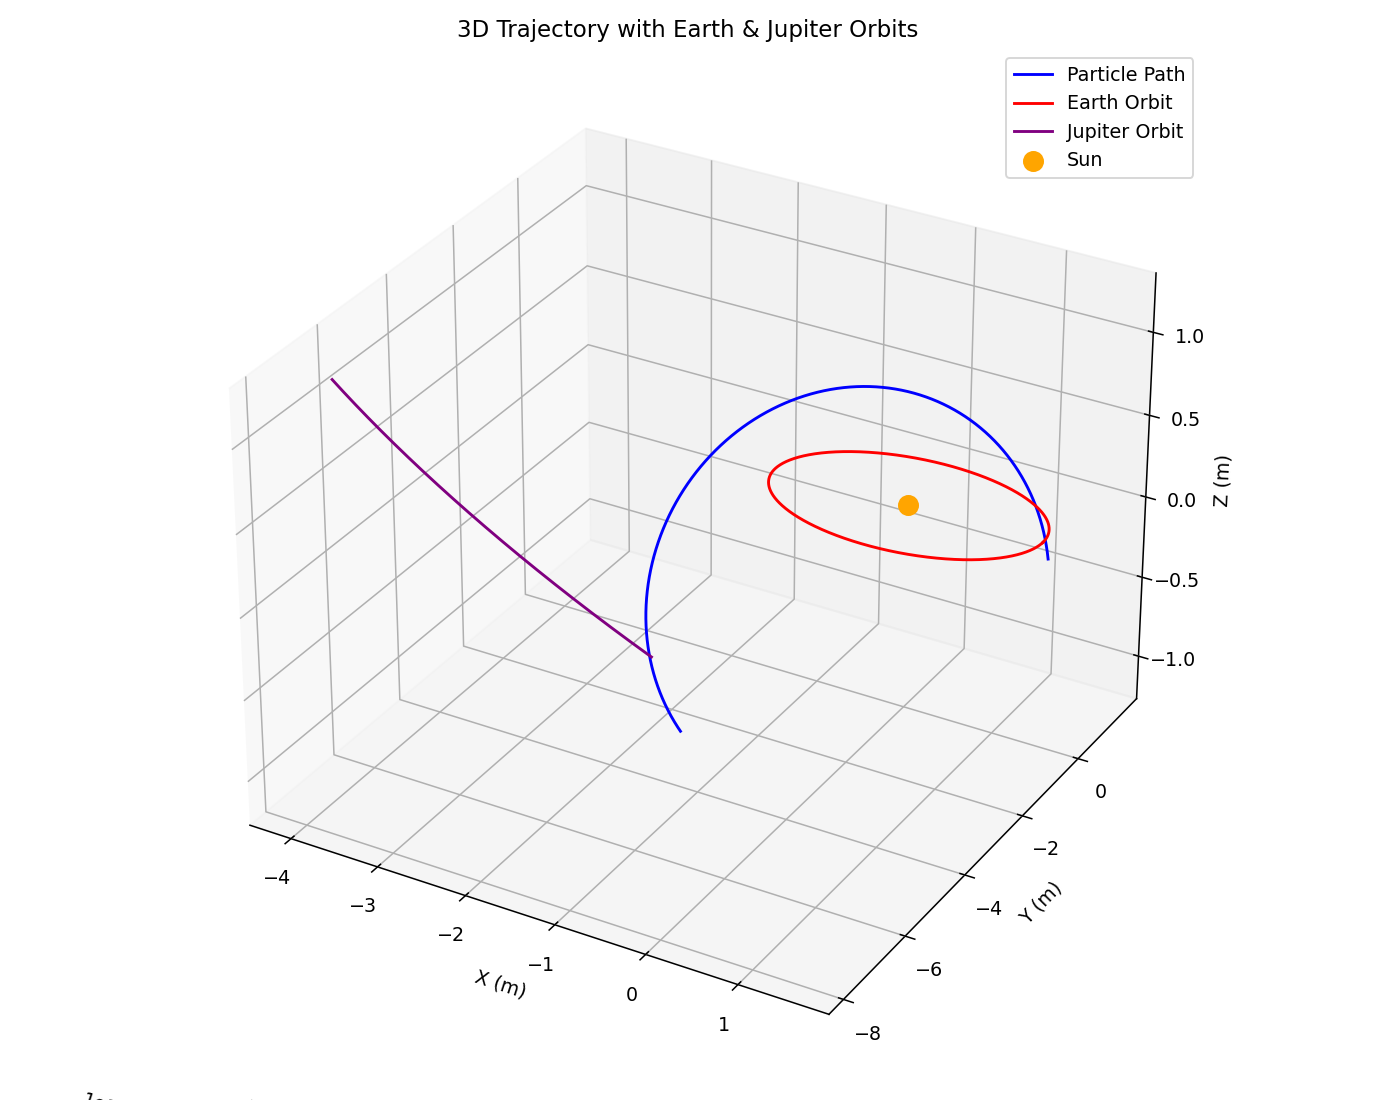

<IPython.core.display.Javascript object>


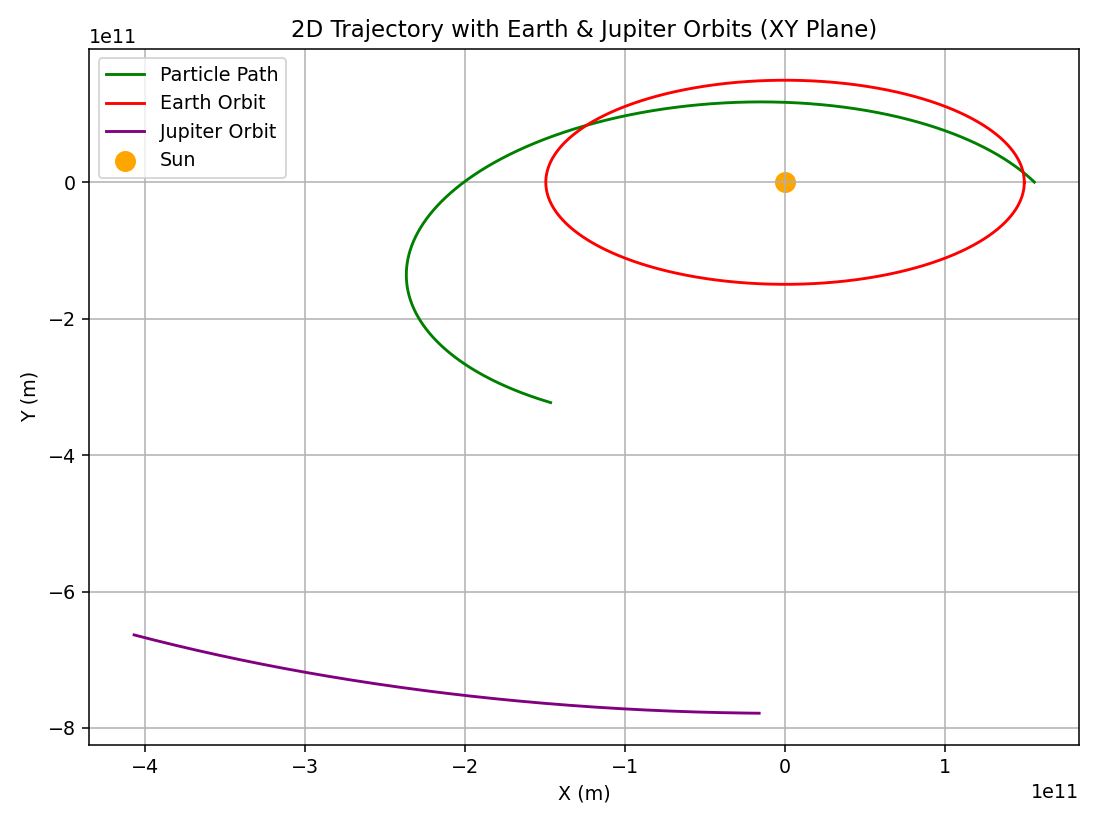

In [31]:
%matplotlib notebook
# --- Run simulation and plot ---
s0 = observer_pos_init
v0 = observer_vel_init
trajectory, collision_type, min_dist, jupiter_min_dist = simulate_one(s0, v0, t_max=T, jupiter_flag=0)

earth_path = get_earth_path(t_max=T)
jupiter_path = get_jupiter_path(t_max=T)

plot_trajectory_3d(trajectory, earth_path, jupiter_path)
plot_trajectory_2d(trajectory, earth_path, jupiter_path)


Sensitivity analysis

<IPython.core.display.Javascript object>


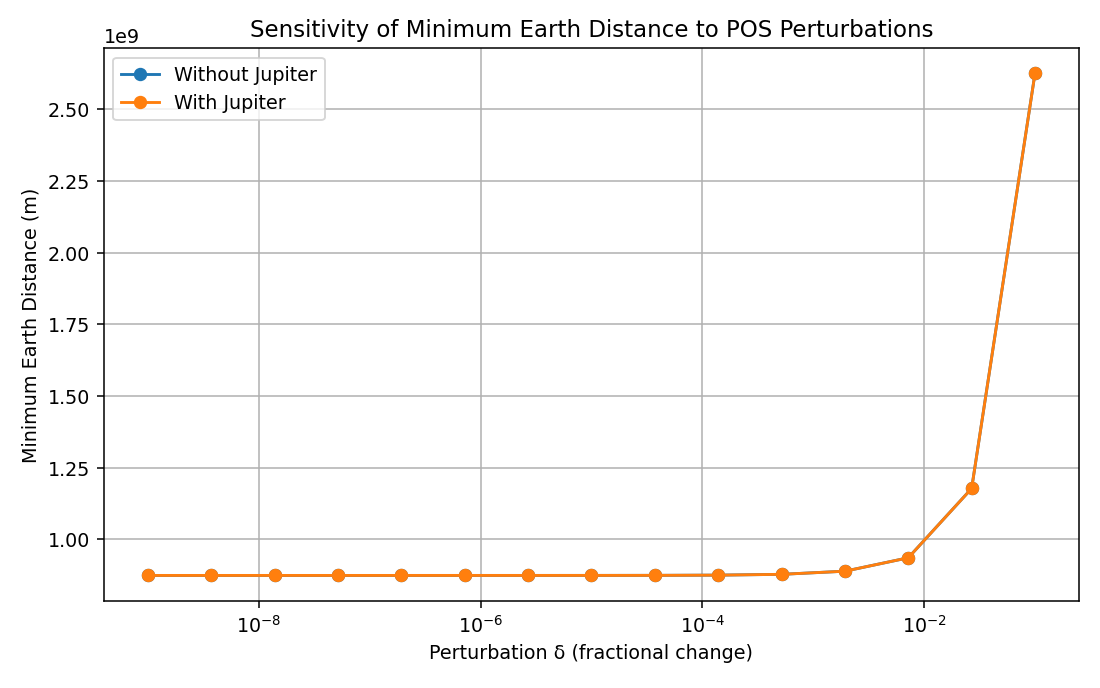

<IPython.core.display.Javascript object>


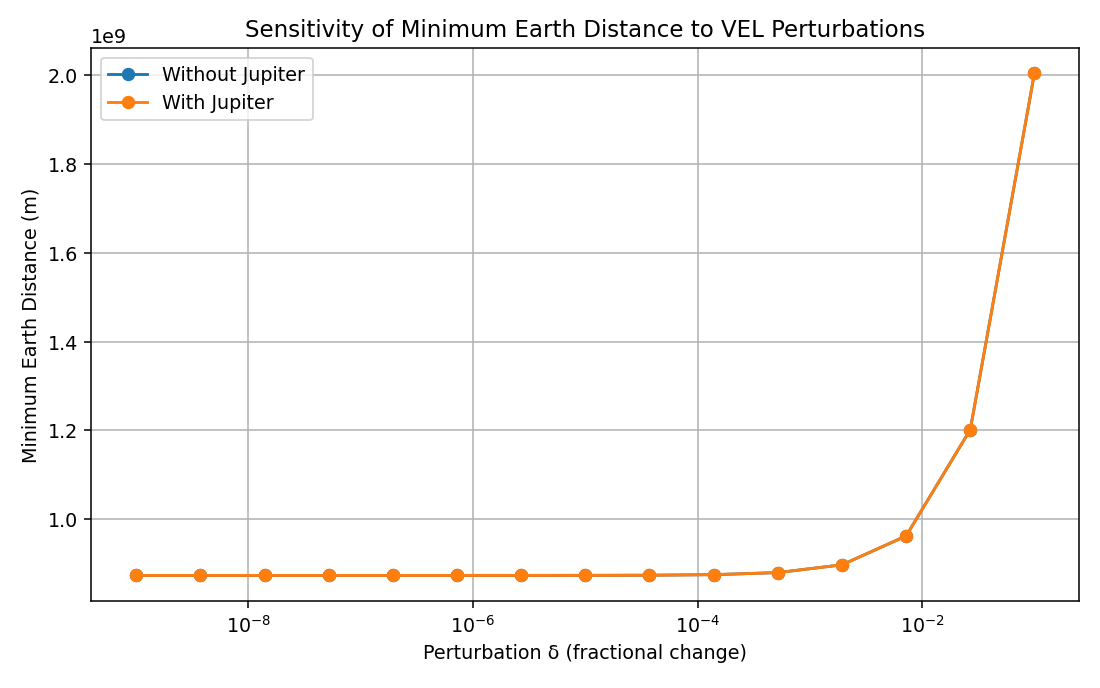

In [32]:
import numpy as np
import matplotlib.pyplot as plt

def sensitivity_plot(observer_pos_init, observer_vel_init, deltas, perturb_type='pos', 
                     t_max_years=5.0, jupiter_flag_vals=[0,1]):

    results = {jflag: [] for jflag in jupiter_flag_vals}
    
    for delta in deltas:
        for jflag in jupiter_flag_vals:
            if perturb_type == 'pos':
                s0 = observer_pos_init * (1 + delta)
                v0 = observer_vel_init.copy()
            elif perturb_type == 'vel':
                s0 = observer_pos_init.copy()
                v0 = observer_vel_init * (1 + delta)
            else:
                raise ValueError("perturb_type must be 'pos' or 'vel'")
            
            # Run simulation (simulate_one returns traj, collision_type, min_dist)
            _, collision, min_dist, jupiter_min_dist = simulate_one(s0, v0, t_max=T*t_max_years, jupiter_flag=jflag)
            results[jflag].append(min_dist)
    
    # Plotting
    plt.figure(figsize=(8,5))
    for jflag in jupiter_flag_vals:
        label = "With Jupiter" if jflag == 1 else "Without Jupiter"
        plt.semilogx(deltas, results[jflag], marker='o', label=label)
    
    plt.xlabel("Perturbation δ (fractional change)")
    plt.ylabel("Minimum Earth Distance (m)")
    plt.title(f"Sensitivity of Minimum Earth Distance to {perturb_type.upper()} Perturbations")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
deltas = np.logspace(-9, -1, 15)  # small fractional perturbations
sensitivity_plot(observer_pos_init, observer_vel_init, deltas, perturb_type='pos')
sensitivity_plot(observer_pos_init, observer_vel_init, deltas, perturb_type='vel')




In [11]:
# =========================
# Utilities to fetch states
# =========================

def get_body_state(name, epoch, id_type='majorbody'):
    """Fetch Cartesian state vector for a planet or asteroid at given epoch (JD)."""
    obj = Horizons(id=name, id_type=id_type, location='@sun', epochs=epoch)
    vec = obj.vectors()
    r = np.array([vec['x'][0], vec['y'][0], vec['z'][0]])  # AU
    v = np.array([vec['vx'][0], vec['vy'][0], vec['vz'][0]])  # AU/day
    return r, v

def to_earth_centered(r_target, v_target, r_earth, v_earth):
    """Transform heliocentric state vector into Earth-centered frame."""
    return r_target - r_earth, v_target - v_earth

# =========================
# Monte Carlo runner
# =========================

def run_simulation_for_asteroid(asteroid_name, jd_start, n_particles=1000):
    """Fetch initial states, transform to Earth frame, run Monte Carlo, save CSV."""
    
    # Earth and Jupiter
    r_earth, v_earth = get_body_state('399', jd_start)       # Earth = 399
    r_jupiter, v_jupiter = get_body_state('599', jd_start)   # Jupiter = 599

    # Asteroid
    r_ast, v_ast = get_body_state(asteroid_name, jd_start, id_type='smallbody')

    # Transform to Earth frame
    r_ast_ec, v_ast_ec = to_earth_centered(r_ast, v_ast, r_earth, v_earth)
    r_jup_ec, v_jup_ec = to_earth_centered(r_jupiter, v_jupiter, r_earth, v_earth)

    # Run Monte Carlo
    results = monte_carlo_sim_from_initials(
        asteroid_name,
        r_ast_ec, v_ast_ec,
        r_jup_ec, v_jup_ec,
        n_particles=n_particles
    )

    # Save
    fname = f"results_{asteroid_name.replace(' ', '_')}.csv"
    results.to_csv(fname, index=False)
    print(f"Saved results for {asteroid_name} → {fname}")

    return results

# =========================
# Driver loop
# =========================

# Example list of asteroids
asteroid_list = ["2025 PM", "99942 Apophis", "1999 KW4"]

# Use JD for 2025-08-17 (just after the flyby)
jd_start = 2460250.5   # Example Julian date

all_results = {}
for asteroid in asteroid_list:
    all_results[asteroid] = run_simulation_for_asteroid(asteroid, jd_start, n_particles=1000)


TypeError: monte_carlo_sim_from_initials() got an unexpected keyword argument 'n_particles'